In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv', parse_dates=['date'], index_col='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv', parse_dates=['date'], index_col='id')
submission_df =  pd.read_csv('/kaggle/input/playground-series-s5e1/sample_submission.csv')

In [4]:
train_df.head()

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,date,country,store,product,num_sold
id,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 230130 entries, 0 to 230129
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   date      230130 non-null  datetime64[ns]
 1   country   230130 non-null  object        
 2   store     230130 non-null  object        
 3   product   230130 non-null  object        
 4   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(3)
memory usage: 10.5+ MB


In [6]:
train_df.isnull().sum()

date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [7]:
#filling in null values with median values
train_df['num_sold']=train_df['num_sold'].fillna(train_df['num_sold'].median())

In [8]:
train_df.isnull().sum()

date        0
country     0
store       0
product     0
num_sold    0
dtype: int64

In [9]:
train_df.describe()

,date,num_sold
count,230130,230130.000000
mean,2013-07-02 00:00:00,746.840529
min,2010-01-01 00:00:00,5.000000
25%,2011-10-02 00:00:00,230.000000
50%,2013-07-02 00:00:00,605.000000
75%,2015-04-02 00:00:00,1084.000000
max,2016-12-31 00:00:00,5939.000000
std,NaN,677.328201


In [10]:
# Extract date features
for df in [train_df, test_df]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekofyear'] = df['date'].dt.isocalendar().week

In [11]:
train_df.head()

,date,country,store,product,num_sold,year,month,day,dayofweek,weekofyear
id,,,,,,,,,,
0,2010-01-01,Canada,Discount Stickers,Holographic Goose,605.0,2010,1,1,4,53
1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,4,53
2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,4,53
3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,4,53
4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,4,53


In [12]:
# Encode categorical columns
encoder = LabelEncoder()
for col in ['country', 'store', 'product']:
    train_df[col] = encoder.fit_transform(train_df[col])
    test_df[col] = encoder.transform(test_df[col])

In [13]:
train_df['country'].unique()

array([0, 1, 2, 3, 4, 5])

In [14]:
train_df['product'].unique()

array([0, 1, 2, 3, 4])

In [15]:
train_df.drop_duplicates(inplace=True)

In [16]:
# Prepare training data
X = train_df[['country', 'store', 'product', 'year', 'month', 'day', 'dayofweek', 'weekofyear']]
y = train_df['num_sold']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Initialize and train models
rf_model = RandomForestRegressor(random_state=42)
dt_model = DecisionTreeRegressor(random_state=42)


In [18]:
rf_model.fit(X_train, y_train)
dt_model.fit(X_train, y_train)

DecisionTreeRegressor(random_state=42)

In [19]:
# Evaluate models
rf_score = rf_model.score(X_val, y_val)
dt_score = dt_model.score(X_val, y_val)

In [20]:
print('Random Forest R^2 Score:', rf_score)
print('Decision Tree R^2 Score:', dt_score)


Random Forest R^2 Score: 0.9888362944872309
Decision Tree R^2 Score: 0.9808462056018972


In [21]:
# Make predictions on the test set
test_X = test_df[['country', 'store', 'product', 'year', 'month', 'day', 'dayofweek', 'weekofyear']]
rf_predictions = rf_model.predict(test_X)
dt_predictions = dt_model.predict(test_X)

In [22]:
# Display sample predictions
print("Random Forest Predictions:", rf_predictions[:5])
print("Decision Tree Predictions:", dt_predictions[:5])

Random Forest Predictions: [605.   783.09 689.5  362.88 413.79]
Decision Tree Predictions: [605. 815. 680. 366. 392.]


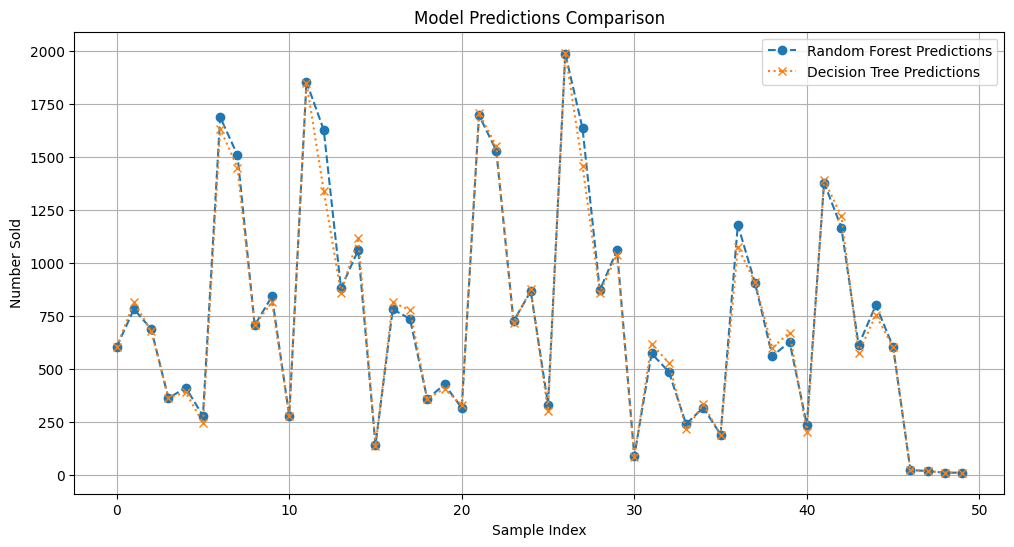

In [23]:
# Plot the Random Forest and Decision Tree predictions
plt.figure(figsize=(12, 6))

plt.plot(rf_predictions[:50], label='Random Forest Predictions', marker='o', linestyle='dashed')
plt.plot(dt_predictions[:50], label='Decision Tree Predictions', marker='x', linestyle='dotted')

plt.title('Model Predictions Comparison')
plt.xlabel('Sample Index')
plt.ylabel('Number Sold')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Save the submission file
submission_df['num_sold'] = rf_predictions
submission_df.to_csv('submission.csv', index=False)
print('Submission file created successfully.')

Submission file created successfully.
